In [40]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir



In [41]:

def crop_brain_contour(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

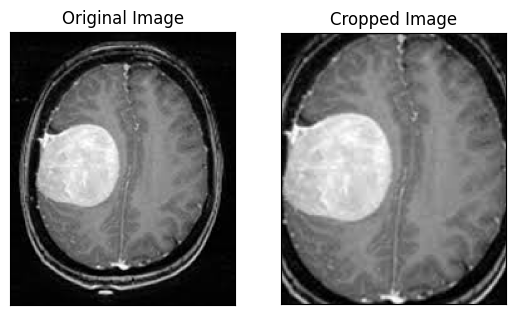

In [42]:
ex_img = cv2.imread('yes/Y1.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

In [43]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them. 
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '\\' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [44]:
augmented_path = 'augmented data/'

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + 'yes' 
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2065
X shape is: (2065, 240, 240, 3)
y shape is: (2065, 1)


In [45]:
def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

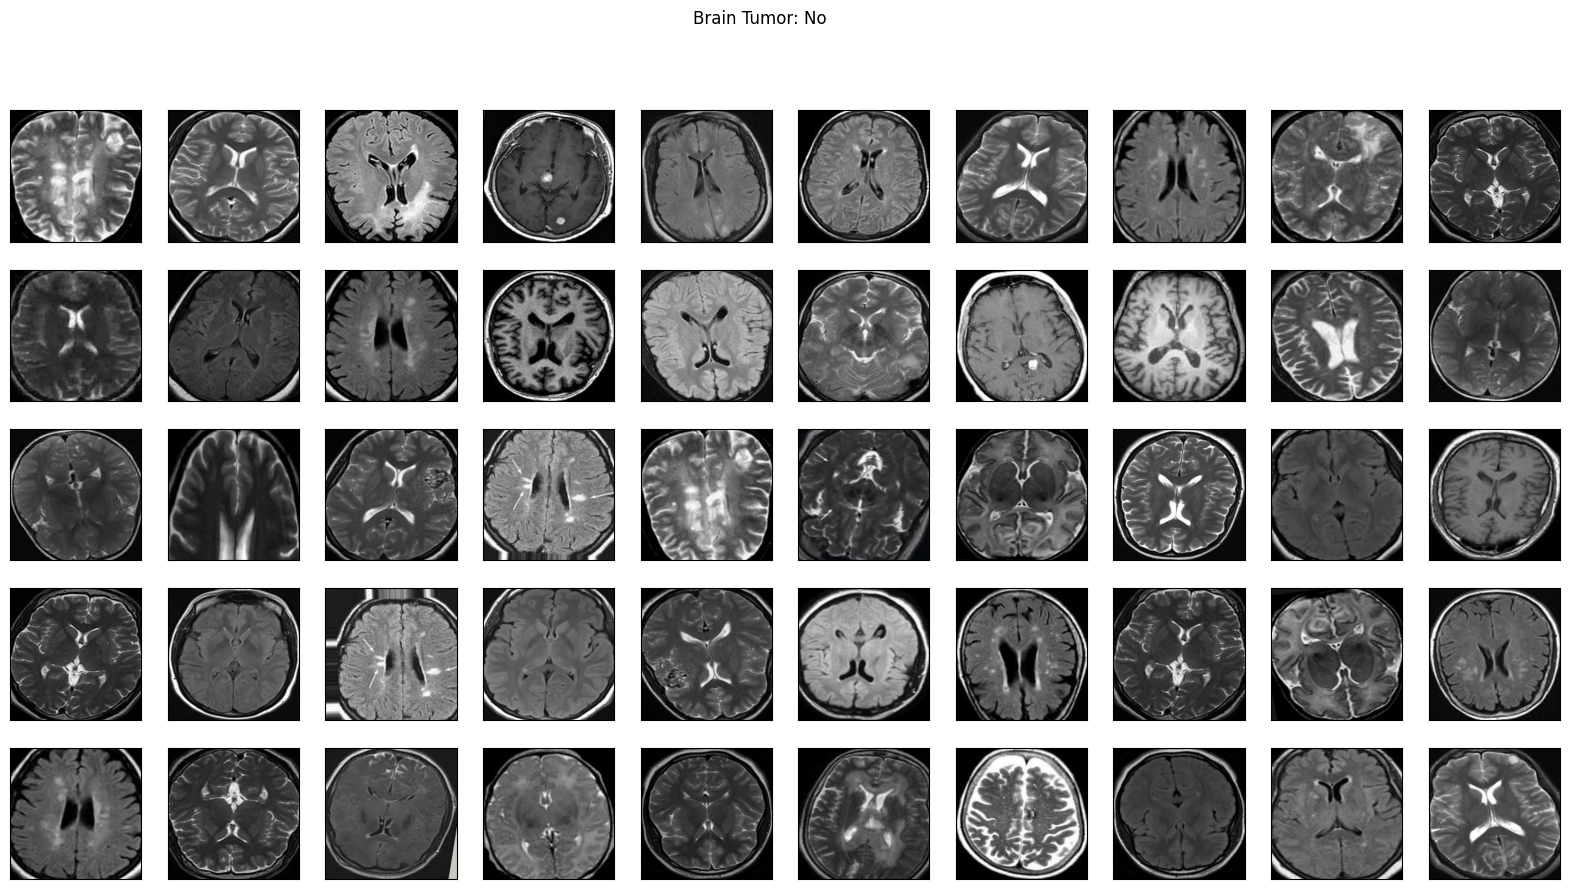

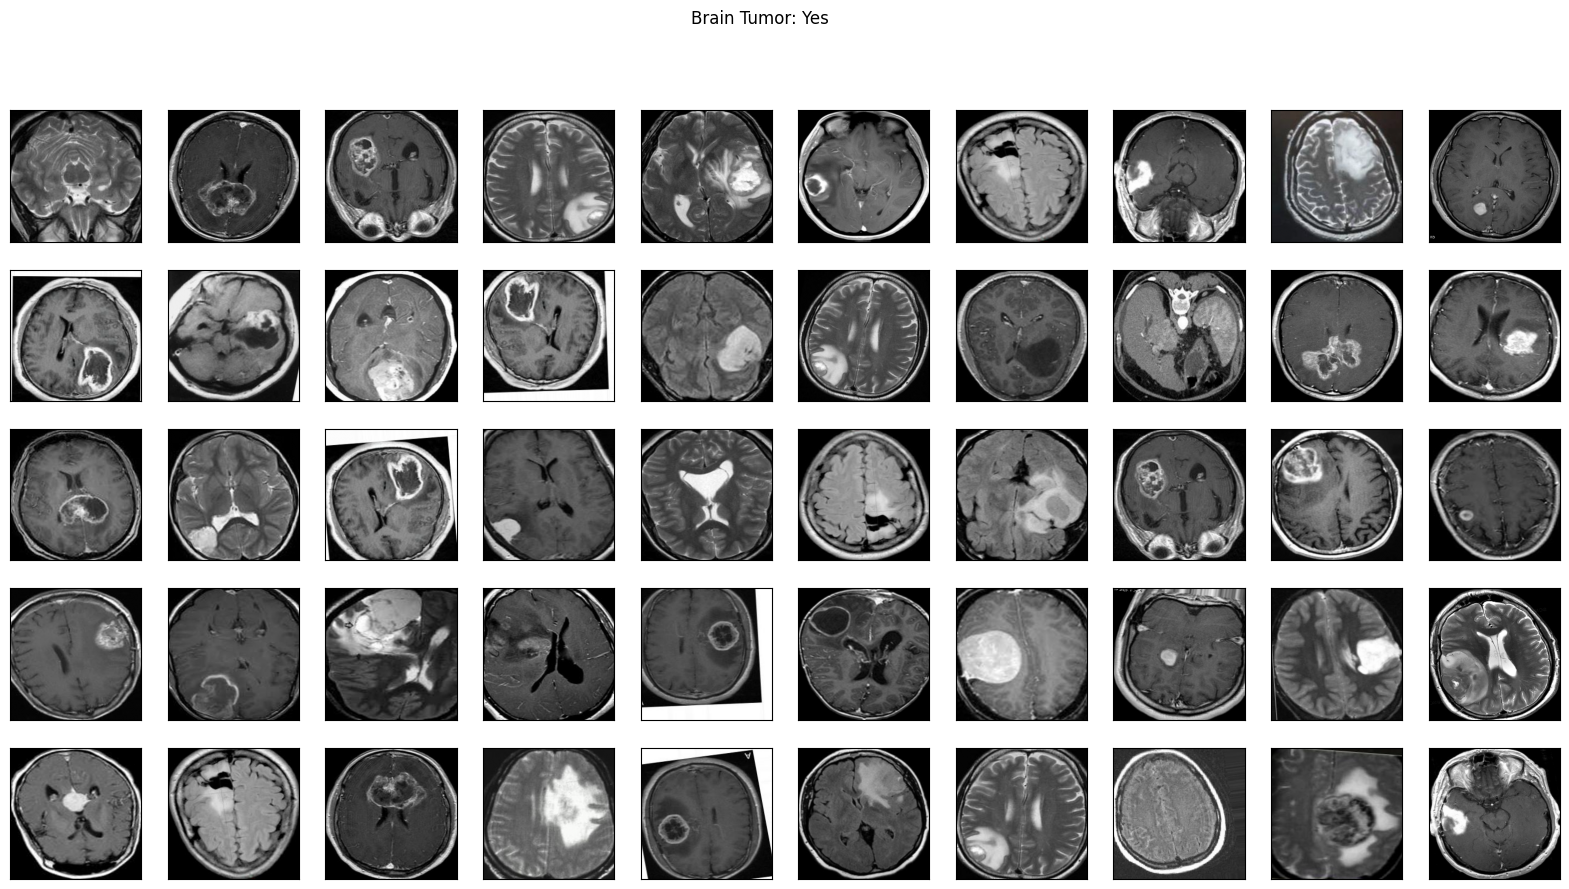

In [46]:
plot_sample_images(X, y)

In [47]:
def split_data(X, y, test_size=0.2):
       
    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [48]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [49]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1445
number of development examples = 310
number of test examples = 310
X_train shape: (1445, 240, 240, 3)
Y_train shape: (1445, 1)
X_val (dev) shape: (310, 240, 240, 3)
Y_val (dev) shape: (310, 1)
X_test shape: (310, 240, 240, 3)
Y_test shape: (310, 1)


In [50]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [51]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

In [52]:
def build_model(input_shape):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

In [53]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [54]:
model = build_model(IMG_SHAPE)

In [55]:
model.summary()

Model: "BrainDetectionModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_1                │ (None, 244, 244, 3)    │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv0 (Conv2D)                  │ (None, 238, 238, 32)   │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn0 (BatchNormalization)        │ (None, 238, 238, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 238, 238, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool0 (MaxPooling2D)        │ (None, 59, 59, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool1 (MaxPooling2D)        │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc (Dense)                      │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,137 (43.50 KB)

 Trainable params: 11,073 (43.25 KB)

 Non-trainable params: 64 (256.00 B)

In [56]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [57]:
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [58]:
from keras.callbacks import ModelCheckpoint

# correct filepath with .keras extension
filepath = "models/cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}.keras"

checkpoint = ModelCheckpoint(
    filepath=filepath,
    monitor='val_accuracy',   # use 'val_accuracy' instead of 'val_acc' (deprecated)
    verbose=1,
    save_best_only=True,
    mode='max'
)


In [59]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 741ms/step - accuracy: 0.5044 - loss: 1.4084
Epoch 1: val_accuracy improved from None to 0.62903, saving model to models/cnn-parameters-improvement-01-0.63.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 37s 776ms/step - accuracy: 0.5813 - loss: 0.9748 - val_accuracy: 0.6290 - val_loss: 0.6555
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 732ms/step - accuracy: 0.7190 - loss: 0.5489
Epoch 2: val_accuracy did not improve from 0.62903
46/46 ━━━━━━━━━━━━━━━━━━━━ 35s 759ms/step - accuracy: 0.7585 - loss: 0.4969 - val_accuracy: 0.5903 - val_loss: 0.6451
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 741ms/step - accuracy: 0.7807 - loss: 0.4710
Epoch 3: val_accuracy improved from 0.62903 to 0.73548, saving model to models/cnn-parameters-improvement-03-0.74.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 35s 768ms/step - accuracy: 0.8118 - loss: 0.4116 - val_accuracy: 0.7355 - val_loss: 0.5846
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 852ms/step - accuracy: 0.8196 - loss: 0.3910
Epoch 4: val_a

In [60]:
history = model.history.history

In [61]:
for key in history.keys():
    print(key)

accuracy
loss
val_accuracy
val_loss


In [62]:
def plot_metrics(history):
    # Ensure we are working with a dict
    history_dict = history if isinstance(history, dict) else history.history

    # Loss
    train_loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    # Accuracy (handle both old and new Keras versions)
    if 'accuracy' in history_dict:
        train_acc = history_dict['accuracy']
        val_acc = history_dict['val_accuracy']
    elif 'acc' in history_dict:
        train_acc = history_dict['acc']
        val_acc = history_dict['val_acc']
    else:
        raise KeyError("No accuracy keys found in history. Available keys: "f"{list(history_dict.keys())}")

    import matplotlib.pyplot as plt

    # Plot Loss
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Loss')

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.show()


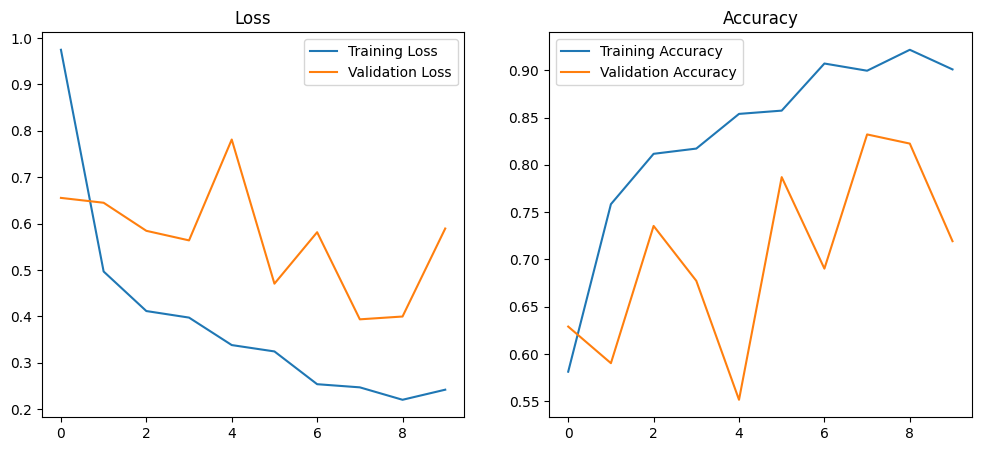

In [63]:
plot_metrics(history)

In [64]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    filepath="models/cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}.keras",
    monitor="val_accuracy",
    verbose=1,
    save_best_only=True,
    mode="max"
)


In [65]:
from keras.models import load_model

best_model = load_model("models/cnn-parameters-improvement-05-0.79.keras")


In [66]:
best_model.metrics_names

['loss', 'compile_metrics']

In [67]:
loss, acc = best_model.evaluate(x=X_test, y=y_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.8806 - loss: 0.4172


In [68]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 0.4172453284263611
Test Accuracy = 0.8806451559066772


In [69]:
y_test_prob = best_model.predict(X_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step


In [70]:
f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score: {f1score}")

F1 score: 0.8951841359773371


In [71]:
y_val_prob = best_model.predict(X_val)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


In [72]:
f1score_val = compute_f1_score(y_val, y_val_prob)
print(f"F1 score: {f1score_val}")

F1 score: 0.8359133126934984


In [73]:
def data_percentage(y):
    
    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}") 



In [74]:
# the whole data
data_percentage(y)

Number of examples: 2065
Percentage of positive examples: 52.54237288135593%, number of pos examples: 1085
Percentage of negative examples: 47.45762711864407%, number of neg examples: 980


In [75]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples: 1445
Percentage of positive examples: 52.6643598615917%, number of pos examples: 761
Percentage of negative examples: 47.3356401384083%, number of neg examples: 684
Validation Data:
Number of examples: 310
Percentage of positive examples: 48.70967741935484%, number of pos examples: 151
Percentage of negative examples: 51.29032258064516%, number of neg examples: 159
Testing Data:
Number of examples: 310
Percentage of positive examples: 55.806451612903224%, number of pos examples: 173
Percentage of negative examples: 44.193548387096776%, number of neg examples: 137


In [76]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, brier_score_loss
import numpy as np
from tensorflow.keras.models import load_model

# --- Load trained model if not already in memory ---
# model = load_model("models/cnn-parameters-improvement-23-0.91.model")  # <-- update path

# --- Make predictions on test set ---
y_pred_probs = model.predict(X_test)   # X_test = your test images
y_pred = (y_pred_probs > 0.5).astype(int)

# --- True labels ---
y_true = y_test   # Make sure you have y_test defined when loading your dataset

# --- Metrics ---
accuracy = accuracy_score(y_true, y_pred) * 100
precision = precision_score(y_true, y_pred, zero_division=0) * 100
recall = recall_score(y_true, y_pred, zero_division=0) * 100
f1 = f1_score(y_true, y_pred, zero_division=0) * 100
dsc = (2 * np.sum(y_true * y_pred)) / (np.sum(y_true) + np.sum(y_pred) + 1e-7) * 100
bs = brier_score_loss(y_true, y_pred_probs)

# --- Print Results ---
print(f"Accuracy: {accuracy:.2f} %")
print(f"Precision: {precision:.2f} %")
print(f"Recall: {recall:.2f} %")
print(f"F1-Score: {f1:.2f} %")
print(f"Dice Similarity Coefficient (DSC): {dsc:.2f} %")
print(f"Brier Score (BS): {bs:.4f}")



10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step
Accuracy: 72.26 %
Precision: 98.88 %
Recall: 50.87 %
F1-Score: 67.18 %
Dice Similarity Coefficient (DSC): 67.18 %
Brier Score (BS): 0.1907
